# Sprint 2

We will start with the feature engineering opportunities from Sprint 1.

- The pitch count for the pitcher in the game.
- Previous at-bat result
- Result of the last pitch
- How to simulate the on-base situation with on_1b, on_2b and on_3b
- Simplify the result and pitch type through data cleaning

## Loading Dataframe

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
#pd.options.mode.chained_assignment = None  # default='warn'

To get more computing power from colab, we will directly access the csv files from google drive

In [2]:
from google.colab import drive
drive.mount('/mnt/drive')

Mounted at /mnt/drive


In [3]:
#Data loading scripts from local Juypter lab terminal
#data_2018 = pd.read_csv('content/sample_data/pitches.csv')
#data_2019 = pd.read_csv('content/sample_data/2019_pitches.csv')
#game_2018 = pd.read_csv('content/sample_data/games.csv')
#game_2019 = pd.read_csv('content/sample_data/2019_games.csv')
#ab_2018 = pd.read_csv('content/sample_data/atbats.csv')
#ab_2019 = pd.read_csv('content/sample_data/2019_atbats.csv')
#name_df = pd.read_csv('content/sample_data/player_names.csv')

In [4]:
data_2018 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/pitches.csv')
data_2019 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/2019_pitches.csv')
game_2018 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/games.csv')
game_2019 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/2019_games.csv')
ab_2018 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/atbats.csv')
ab_2019 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/2019_atbats.csv')
name_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/player_names.csv')

In [5]:
pitch_df = pd.concat([data_2018, data_2019])
game_df = pd.concat([game_2018, game_2019])
ab_df = pd.concat([ab_2018, ab_2019])
abdata = pitch_df.merge(ab_df, on = "ab_id")
gamedata = abdata.merge(game_df, on = 'g_id')
gamedata1 =pd.merge(gamedata, name_df, left_on='batter_id', right_on='id', how = 'left')

In [6]:
gamedata1.shape

(3595944, 69)

We will remove the columns that will not be used for this project to reduce the memory usage

In [7]:
gamedata1 = gamedata1.drop(columns=['spin_rate', 'spin_rate','spin_dir','break_angle','break_length','break_y'])
gamedata1 = gamedata1.drop(columns=['ax', 'ay','az'])
gamedata1 = gamedata1.drop(columns=['type_confidence'])
gamedata1 = gamedata1.drop(columns=['vx0', 'vy0','vz0','x','x0','y', 'y0','z0','pfx_x','pfx_z'])
gamedata1 = gamedata1.drop(columns=['event_num', 'away_final_score','away_team','date','elapsed_time','home_final_score', 'home_team','start_time'])
gamedata1 = gamedata1.drop(columns=['umpire_1B', 'umpire_2B','umpire_3B','umpire_HP','venue_name','delay', 'id','first_name','last_name'])

In [8]:
gamedata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595944 entries, 0 to 3595943
Data columns (total 33 columns):
 #   Column       Dtype  
---  ------       -----  
 0   px           float64
 1   pz           float64
 2   start_speed  float64
 3   end_speed    float64
 4   sz_bot       float64
 5   sz_top       float64
 6   nasty        float64
 7   zone         object 
 8   code         object 
 9   type         object 
 10  pitch_type   object 
 11  b_score      float64
 12  ab_id        float64
 13  b_count      float64
 14  s_count      float64
 15  outs         float64
 16  pitch_num    float64
 17  on_1b        float64
 18  on_2b        float64
 19  on_3b        float64
 20  batter_id    int64  
 21  event        object 
 22  g_id         float64
 23  inning       float64
 24  o            int64  
 25  p_score      float64
 26  p_throws     object 
 27  pitcher_id   int64  
 28  stand        object 
 29  top          object 
 30  attendance   float64
 31  weather      object 
 32

In [9]:
gamedata1.isna().sum()

px              20818
pz              20818
start_speed     20743
end_speed       20743
sz_bot           2083
sz_top           2083
nasty          742979
zone            20818
code             5719
type                0
pitch_type      20818
b_score             0
ab_id               0
b_count             0
s_count             0
outs                0
pitch_num           0
on_1b               0
on_2b               0
on_3b               0
batter_id           0
event               0
g_id                0
inning              0
o                   0
p_score             0
p_throws            0
pitcher_id          0
stand               0
top                 0
attendance     728790
weather        728790
wind           728790
dtype: int64

As we are checking the columns containing N/A values, we have to remove empty rows for column px, pz and pitch_type as these are the target variables after getting the pitch count feature.


## Feature Engineering on Pitch Count

### Spliting dataframe to top and bottom innings

Because teams switch fielding positions by half innings, splitting the dataframe by top and bottom innings makes sure that we can process the pitching of the same team in one cluster later on.

In [10]:
gamedata1['top'].value_counts()

top
True     1831115
False    1764829
Name: count, dtype: int64

In [11]:
top_ins = gamedata1[gamedata1['top'] ==True]
bot_ins = gamedata1[gamedata1['top'] == False]

### Pitch Count

Pitch count represents the game status of the current pitcher. First, pitchers get tired after repeatingly throwing. The more someone pitches, the more likely he will lose control or speed of his pitch due to fatigue. On the other hand, the hitter will observe the pitches throughout the game. When one pitcher makes adquate number of pitches, the hitter will "figure out" the pitcher's strategy as well as pitching mix .These leads to advantage for hitter and helps them to make a good hit.

Luckily, the dataframe is pitch-by-pitch record, which means games are grouped together with the pitch-by-pitch sequence. We will divide the dataframe to top innings and bottom innings, give pitch count to each row and update the original dataframe.


### Generating Pitch Count for top innings (away team)

In [12]:
#Initiate the pitch_count column
top_ins['pitch_count'] = 1

<ipython-input-12-4ef215ae57e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins['pitch_count'] = 1


In [13]:
count = 1
for i in range(len(top_ins)):
    if (top_ins['pitcher_id'].iloc[i] == top_ins['pitcher_id'].iloc[i-1]):
        count = count + 1 ## if the previous row and the current row is the same pitcher, add count
    else:
        count = 1
    top_ins.loc[top_ins.index[i], 'pitch_count'] = count

### Generating Pitch Count for bottom innings (home team)

In [14]:
bot_ins['pitch_count'] = 1

<ipython-input-14-5ced665786c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins['pitch_count'] = 1


In [15]:
count = 1
for i in range(len(bot_ins)):
    if (bot_ins['pitcher_id'].iloc[i] == bot_ins['pitcher_id'].iloc[i-1]):
        count = count + 1
    else:
        count = 1
    bot_ins.loc[bot_ins.index[i], 'pitch_count'] = count

In [16]:
bot_ins[['pitch_count','pitcher_id']][60:120]

,pitch_count,pitcher_id
134,61,425794
135,62,425794
136,63,425794
137,64,425794
138,65,425794
165,66,425794
166,67,425794
167,68,425794
168,69,425794
169,70,425794


### Updating Pitch count to original dataframe

In [17]:
gamedata1['pitch_count'] = 0
gamedata1.update(top_ins)
gamedata1.update(bot_ins)

## Removing Rows #1

After generating the pitch count, we can safely remove the rows containing N/A values so that the sequence of the pitches will not be disrupted.

However, because we intend to use Recurrent neural network to train the model, it won't be able to handle data when there's a missing data in the sequence.

For example, the RNN model will happily look at the data pitch 1 to pitch 5. But if the data of pitch 3 is missing and we removed this row, RNN model won't effectively analysis the sequence.

To avoid that, we will remove the pitching data of a pitcher in the whole game whose pitching data is missing even 1 pitch. We will not remove the data for the whole game as pitcher will rotate.

In [18]:
na_pitch_data = gamedata1[gamedata1['pitch_type'].isna()]

na_pitch_list = na_pitch_data[['g_id','pitcher_id']].drop_duplicates()

The N/A cell number for px & pz is the same as pitch type, which hints the possibility that these are the same rows. We will drop N/A cells in column 'pitch_type' and remove more rows if necessary.

After that, we will list the game_id and pitcher_id that are missing pitch type data.

In [19]:
na_pitch_list

,g_id,pitcher_id
344,201500002.00,450308
684,201500003.00,506693
1597,201500006.00,543359
2791,201500011.00,456501
4282,201500017.00,502009
...,...,...
3594502,201902404.00,642098
3594576,201902404.00,641793
3594897,201902405.00,544928
3595367,201902407.00,592662


In [20]:
to_remove = gamedata1.merge(na_pitch_list, on=['g_id', 'pitcher_id'], how='inner')

# Remove these rows from the original DataFrame
gamedata_clean = gamedata1[~gamedata1.set_index(['g_id', 'pitcher_id']).index.isin(na_pitch_list.set_index(['g_id', 'pitcher_id']).index)]


In [21]:
gamedata_clean.isna().sum()

px                  0
pz                  0
start_speed         0
end_speed           0
sz_bot              0
sz_top              0
nasty          675488
zone                0
code             5616
type                0
pitch_type          0
b_score             0
ab_id               0
b_count             0
s_count             0
outs                0
pitch_num           0
on_1b               0
on_2b               0
on_3b               0
batter_id           0
event               0
g_id                0
inning              0
o                   0
p_score             0
p_throws            0
pitcher_id          0
stand               0
top                 0
attendance     675488
weather        675488
wind           675488
pitch_count         0
dtype: int64

After removing these data, px, pz and pitch type don't have N/A value anymore.

In [22]:
gamedata_clean.shape

(3311559, 34)

#### Check placeholder

In Sprint1, we notice zone column has a value called 'placeholder'. Zone column are determined by px and pz. Both will serve as coordinates, and zone reprents the area on the strike zone map.

We will check if any other colomns contains this value. This will be dealt with later on.

In [23]:
mask_placeholder = gamedata_clean.applymap(lambda x: 'placeholder' in str(x))

# Check which columns contain 'placeholder'
columns_with_placeholder = mask_placeholder.any()

print(columns_with_placeholder)

px             False
pz             False
start_speed    False
end_speed      False
sz_bot         False
sz_top         False
nasty          False
zone            True
code           False
type           False
pitch_type     False
b_score        False
ab_id          False
b_count        False
s_count        False
outs           False
pitch_num      False
on_1b          False
on_2b          False
on_3b          False
batter_id      False
event          False
g_id           False
inning         False
o              False
p_score        False
p_throws       False
pitcher_id     False
stand          False
top            False
attendance     False
weather        False
wind           False
pitch_count    False
dtype: bool


## Simplified pitch type

As done in Sprint 1, we will simply the pitch type to 4 classes to reduce the complexity of classification.
- Fastball
- Breaking ball
- Off-speed
- Other

In [24]:
dictionary_pitch = {'CH':'Off-speed',
                'CU':'Breaking',
                'EP':'Other',
                'FC':'Fastball',
                'FF':'Fastball',
                'FO':'Other',
                'FS':'Off-speed',
                'FT':'Fastball',
                'IN':'Other',
                'KC':'Breaking',
                'KN':'Breaking',
                'PO':'Other',
                'SC':'Off-speed',
                'SI':'Fastball',
                'SL':'Breaking',
                'UN':'Other',
                'FA':'Fastball',
                'AB':'Other'
                }

In [25]:
simple_pitch_types = [dictionary_pitch[pitch_type] for pitch_type in gamedata_clean['pitch_type']]
gamedata_clean['simple_pitch_type'] = simple_pitch_types

<ipython-input-25-799c29b74e11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['simple_pitch_type'] = simple_pitch_types


## Simplified At-Bat Result

We will use the previous at-bat result as a feature later on. Let's take a look at the unique kinds of events. Note that this is the result of the at-bat, pitcher usually pitch 5+ balls and at-bat is considered over with one of these results.

In [26]:
gamedata_clean['event'].value_counts()

event
Strikeout                       893179
Groundout                       536893
Single                          419722
Walk                            382295
Flyout                          316937
Lineout                         177740
Pop Out                         137777
Double                          126393
Home Run                         90366
Forceout                         54178
Grounded Into DP                 52649
Hit By Pitch                     25703
Field Error                      24697
Sac Fly                          17380
Triple                           13263
Sac Bunt                          7891
Double Play                       6819
Intent Walk                       6634
Fielders Choice Out               4473
Runner Out                        3975
Strikeout - DP                    3334
Bunt Groundout                    2361
Fielders Choice                   2352
Bunt Pop Out                      1067
Strikeout Double Play              872
Catcher Interferenc

49 types of outcome. This will absolutely create issues when we feature engineer the "previous at-bat result" and put it to dummy variables. We will set the following rules:
- If the batter advances one base, it's a hit. Walk, HBP will be considered as a hit as well.
- If the batter advances more than one base, it's a slug. We distingtish this from a hit to show the extra damage the batter has created.
- If the batter is out, it's an out.
- If there's more than 1 out, it's a double play. We distingtish this from an out to show the extra advantage the pitcher and defense has gained.
- The rest of the event is called 'Other'.

In [27]:
dictionary_event = {'Strikeout':'Out',
                'Groundout':'Out',
                'Single':'Hit',
                'Walk':'Hit',
                'Flyout':'Out',
                'Lineout':'Out',
                'Pop Out':'Out',
                'Double':'Slug',
                'Home Run':'Slug',
                'Forceout':'Out',
                'Grounded Into DP':'DP',
                'Hit By Pitch':'Hit',
                'Field Error':'Other',
                'Sac Fly':'Other',
                'Intent Walk':'Hit',
                'Triple':'Slug',
                'Sac Bunt':'Other',
                'Double Play':'DP',
                'Fielders Choice Out':'Out',
                'Runner Out':'Out',
                'Strikeout - DP':'DP',
                'Fielders Choice':'Out',
                'Bunt Groundout':'Out',
                'Bunt Pop Out':'Out',
                'Strikeout Double Play':'DP',
                'Catcher Interference':'Other',
                'Batter Interference':'Other',
                'Caught Stealing 2B':'Out',
                'Sac Fly DP':'DP',
                'Fan Interference':'Other',
                'Bunt Lineout':'Out',
                'Pickoff Caught Stealing 2B':'Other',
                'Triple Play':'DP',
                'Pickoff 1B':'Other',
                'Caught Stealing Home':'Out',
                'Sac Fly Double Play':'DP',
                'Caught Stealing 3B':'Out',
                'Pickoff 2B':'Other',
                'Pickoff Caught Stealing Home':'Out',
                'Wild Pitch':'Other',
                'Pickoff 3B':'Other',
                'Sacrifice Bunt DP':'DP',
                'Sac Bunt Double Play':'DP',
                'Runner Double Play':'DP',
                'Pickoff Caught Stealing 3B':'Out',
                'Game Advisory':'Other',
                'Pickoff Caught Stealing Home':'Out',
                'Passed Ball':'Other',
                'Pickoff Error 1B':'Other',
                'Stolen Base 2B':'Other'
                }


In [28]:
# Update to a new column
simple_ab_event = [dictionary_event[event_type] for event_type in gamedata_clean['event']]
gamedata_clean['simple_ab_event'] = simple_ab_event

<ipython-input-28-3d0a61c0a531>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['simple_ab_event'] = simple_ab_event


## Count Difference

The rule of baseball pitching is that if 4 bad pitches (ball) are made, batter can walk to the first base. If 3 good pitchers (strike) are made, batter is out. Ball count serves as a tool to show who's at advantage.

Suppose the current count is 3 ball and no strike, then the pitcher has the pressure to throw strikes, otherwise the batter will get free base. On the other hand, if the count is 1 ball 2 strikes, then the batter has two more chances to throw ball. They might intentionally throw breaking balls that induce batters to swing and miss, thus strikeing them out.

We will simply use ball count - strike count to show the difference.

In [29]:
gamedata_clean['b_count_diff'] = gamedata_clean['b_count'] - gamedata_clean['s_count']

<ipython-input-29-41f1632e72f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['b_count_diff'] = gamedata_clean['b_count'] - gamedata_clean['s_count']


## Run Difference

For some reason, baseball calls score as run. So this is simply showing the score difference. Note that the difference is calculated using the pitcher's team's score minus the opposite side's score. The sign of this run difference will change when changing between top and bottom innings.

In [30]:
gamedata_clean['run_diff'] = gamedata_clean['p_score'] - gamedata_clean['b_score']

<ipython-input-30-2d5576de9293>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['run_diff'] = gamedata_clean['p_score'] - gamedata_clean['b_score']


In [31]:
gamedata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 3595943
Data columns (total 38 columns):
 #   Column             Dtype  
---  ------             -----  
 0   px                 float64
 1   pz                 float64
 2   start_speed        float64
 3   end_speed          float64
 4   sz_bot             float64
 5   sz_top             float64
 6   nasty              float64
 7   zone               object 
 8   code               object 
 9   type               object 
 10  pitch_type         object 
 11  b_score            float64
 12  ab_id              float64
 13  b_count            float64
 14  s_count            float64
 15  outs               float64
 16  pitch_num          float64
 17  on_1b              float64
 18  on_2b              float64
 19  on_3b              float64
 20  batter_id          int64  
 21  event              object 
 22  g_id               float64
 23  inning             float64
 24  o                  int64  
 25  p_score            floa

## Split to top and bottom again

We will move on to the feature engineering for previous result that shows some idea of recurrent. It's important to split the dataframe to top and bottom innings again.

In [32]:
top_ins = gamedata_clean[gamedata_clean['top'] ==True]
bot_ins = gamedata_clean[gamedata_clean['top'] == False]

## Previous at-bat result

Previous at-bat result generally serves as an indicator of "Advantage". Consecutive hits probably shows the last pitch is not good enough or has been anticpated. In other words, it's a signal for pitcher to keep or adjust their pitching strategy.

It's important to note that there's an underlying assumption. Are each at-bats related to each other? Are each innings connected to each other?

In [33]:
ab_df['event'].value_counts()

event
Strikeout                       199405
Groundout                       166734
Single                          134520
Flyout                          100488
Walk                             71903
Lineout                          55960
Pop Out                          43115
Double                           41582
Home Run                         28927
Forceout                         18653
Grounded Into DP                 18141
Hit By Pitch                      8901
Field Error                       7728
Sac Fly                           5901
Sac Bunt                          4738
Intent Walk                       4531
Triple                            4236
Double Play                       2208
Runner Out                        1778
Fielders Choice Out               1535
Bunt Groundout                    1479
Fielders Choice                    801
Bunt Pop Out                       681
Strikeout - DP                     580
Catcher Interference               213
Batter Interference

It will be tough to locate last pitch from the pitch-by-pitch script. Luckily, the ab_df dataframe contains the at-bat result, same as the 'event' column from our main dataframe. We will encode the event column in ab_df, look up the previous at-bat id and bring the simplied event to a new column.

In [34]:
simple_ab_event = [dictionary_event[event_type] for event_type in ab_df['event']]
ab_df['simple_ab_event'] = simple_ab_event

In [35]:
result = ""
for i in range(len(top_ins)):
    if (top_ins['g_id'].iloc[i] != top_ins['g_id'].iloc[i-1]): # Make sure to set first AB for the first ab-bat of the game
        result = "FirstAB"
    else:
        if (top_ins['ab_id'].iloc[i] != top_ins['ab_id'].iloc[i-1]):
            matching_index = ab_df[ab_df['ab_id'] == top_ins['ab_id'].iloc[i-1]].index[0]
            result = ab_df.iloc[matching_index]['simple_ab_event']
    top_ins.loc[top_ins.index[i], 'prvs_ab'] = result

<ipython-input-35-a40d60580f47>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins.loc[top_ins.index[i], 'prvs_ab'] = result


In [36]:
top_ins[['event','prvs_ab']].head(20)

,event,prvs_ab
0,Groundout,FirstAB
1,Groundout,FirstAB
2,Groundout,FirstAB
3,Groundout,FirstAB
4,Groundout,FirstAB
5,Groundout,FirstAB
6,Double,Out
7,Double,Out
8,Single,Slug
9,Single,Slug


In [37]:
# Rpeat the same for bottom innings
result = ""
for i in range(len(bot_ins)):
    if (bot_ins['g_id'].iloc[i] != bot_ins['g_id'].iloc[i-1]):
        result = "FirstAB"
    else:
        if (bot_ins['ab_id'].iloc[i] != bot_ins['ab_id'].iloc[i-1]):
            matching_index = ab_df[ab_df['ab_id'] == bot_ins['ab_id'].iloc[i-1]].index[0]
            result = ab_df.iloc[matching_index]['simple_ab_event']
    bot_ins.loc[bot_ins.index[i], 'prvs_ab'] = result

<ipython-input-37-f966b582f4bd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins.loc[bot_ins.index[i], 'prvs_ab'] = result


## Previous Pitch Type

Previous pitch type will show the combination of pitches. Famous combo includes fastball + off-speed to make the hitting hard, or fastball+breaking ball to make it hard predicting the pitch location.

Note that the first pitch of each game and each pitcher will be encoded as 'First pitch' as I assume the sequence doesn't last between games and between pitchers.

In [38]:
result = ""
for i in range(len(top_ins)):
    if (top_ins['g_id'].iloc[i] != top_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (top_ins['pitcher_id'].iloc[i] != top_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = top_ins['simple_pitch_type'].iloc[i-1]
    top_ins.loc[top_ins.index[i], 'prvs_pitch'] = result

<ipython-input-38-2c93a49ac2c4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins.loc[top_ins.index[i], 'prvs_pitch'] = result


In [39]:
result = ""
for i in range(len(bot_ins)):
    if (bot_ins['g_id'].iloc[i] != bot_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (bot_ins['pitcher_id'].iloc[i] != bot_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = bot_ins['simple_pitch_type'].iloc[i-1]
    bot_ins.loc[bot_ins.index[i], 'prvs_pitch'] = result

<ipython-input-39-bc1279059410>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins.loc[bot_ins.index[i], 'prvs_pitch'] = result


## Previous Pitch Result

We can consider this to be a more detailed version of strike-ball count and previous ab-bat result. Same as at-bat result, it's a signal for pitcher to determine if the stragegy is working. Same as strike-ball count, pitcher needs to update the count and realize what they should do next.

In [40]:
result = ""
for i in range(len(top_ins)):
    if (top_ins['g_id'].iloc[i] != top_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (top_ins['pitcher_id'].iloc[i] != top_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = top_ins['type'].iloc[i-1]
    top_ins.loc[top_ins.index[i], 'prvs_pitch_result'] = result

<ipython-input-40-ce226d87f293>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins.loc[top_ins.index[i], 'prvs_pitch_result'] = result


In [41]:
result = ""
for i in range(len(bot_ins)):
    if (bot_ins['g_id'].iloc[i] != bot_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (bot_ins['pitcher_id'].iloc[i] != bot_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = bot_ins['type'].iloc[i-1]
    bot_ins.loc[bot_ins.index[i], 'prvs_pitch_result'] = result

<ipython-input-41-fd28c5229206>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins.loc[bot_ins.index[i], 'prvs_pitch_result'] = result


## Starting Pitcher vs. Relief Pitcher

A starting pitcher usually will pitch for 5+ innings with around 80 pitches from the start of the game. In comparison, relief pitchers usually pitch for 1 to 2 innings in the middle of the game. These two roles have the following difference due to the nature of their responsibility:
- Starting pitchers usually have 3-4 good types of pitching. Relief pitchers usually only have 2.
- Starting pitchers needs to perserve energy for late innings. They will not throw as hard as relief pitcher, especially on fastballs.

These differences make both have different pitching strategies. It feels essential to classify if someone is relief pitcher or starting pitcher. Consider the following two situations:
- Starter got pulled from mount on a particular game because of injury or poor performance. He only had 20 pitches but relief pitcher has to take over.
- The team doesn't have enough starting pitcher to fill the rotation. A relief pitcher has to start the game and is replaced after 2 innings. (Also called bullpen day).

To accurately classify the role, we will look each pitcher's maximum pitch count through the dataframe. If he ever pitched more than 50 pitches, he should be considered as a starting pitcher.

First, we will find maximum(final) pitch count for each pithcer in their games. If the maximum pitch count is more than 50 then he's a SP, otherwise he's a RP.

In [42]:
max_pitch_1 = top_ins.groupby('pitcher_id')['pitch_count'].max()
max_pitch_1 = max_pitch_1.reset_index()
max_pitch_1['SPorRP'] = ['SP' if value > 50 else 'RP' for value in max_pitch_1['pitch_count']]
max_pitch_2 = bot_ins.groupby('pitcher_id')['pitch_count'].max()
max_pitch_2 = max_pitch_2.reset_index()
max_pitch_2['SPorRP'] = ['SP' if value > 50 else 'RP' for value in max_pitch_2['pitch_count']]

In [43]:
top_ins.merge(max_pitch_1[['pitcher_id', 'SPorRP']], on='pitcher_id', how='left');
bot_ins.merge(max_pitch_2[['pitcher_id', 'SPorRP']], on='pitcher_id', how='left');


In [44]:
top_ins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1684977 entries, 0 to 3595943
Data columns (total 41 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   px                 1684977 non-null  float64
 1   pz                 1684977 non-null  float64
 2   start_speed        1684977 non-null  float64
 3   end_speed          1684977 non-null  float64
 4   sz_bot             1684977 non-null  float64
 5   sz_top             1684977 non-null  float64
 6   nasty              1340318 non-null  float64
 7   zone               1684977 non-null  object 
 8   code               1681927 non-null  object 
 9   type               1684977 non-null  object 
 10  pitch_type         1684977 non-null  object 
 11  b_score            1684977 non-null  float64
 12  ab_id              1684977 non-null  float64
 13  b_count            1684977 non-null  float64
 14  s_count            1684977 non-null  float64
 15  outs               1684977 non-null  

## Strike zone number

Strike zone number serves as a back up for pitch location (px and pz). In case the result of px and pz is not very readable, batter can use strike zone as a reference of where the pitch will go.
In Sprint 1, it's noted that 722161 cells only has 'placeholder' value while px and pz are given. We will fill it out with simple if statments.


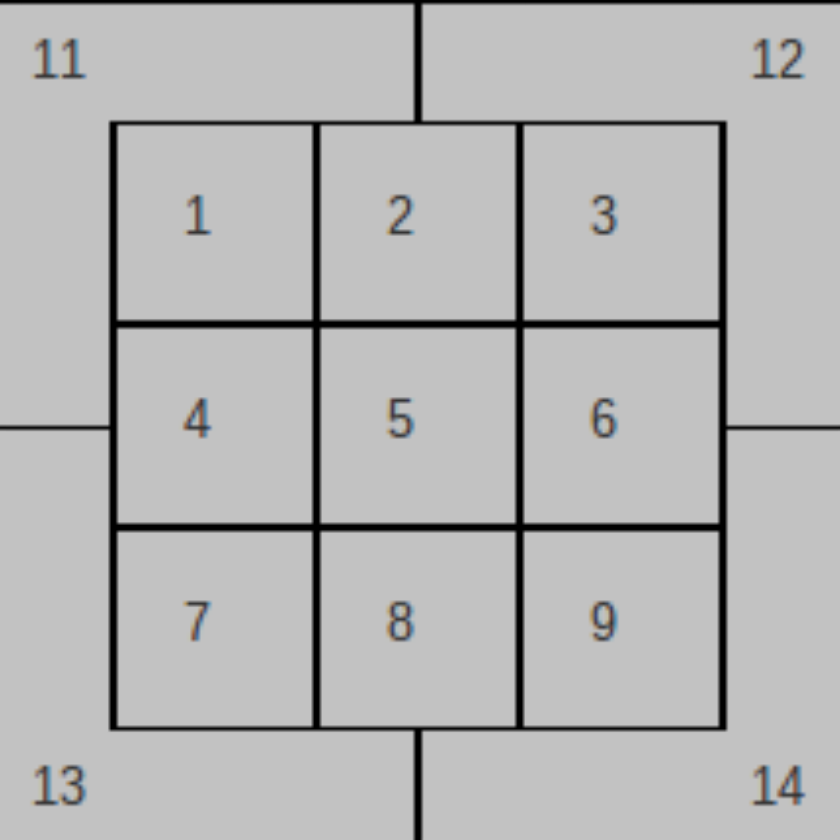

from https://www.beyondtheboxscore.com/2014/7/21/5921769/babip--strikezone-location-mlb

Just to declare, the strke zone will be 1.54 feet wide. Height is determined by the batter's body size, so it's between sz_top and sz_bot.

In [45]:
sz_bot_avg = gamedata_clean['sz_bot'].mean()
sz_top_avg = gamedata_clean['sz_top'].mean()

In [46]:
# Filter for placeholder cells
top_ins_na = top_ins[top_ins['zone'] == 'placeholder']

In [47]:
#mask for strike zone
px = top_ins_na['px']
pz = top_ins_na['pz']
sz_top = top_ins_na['sz_top']
sz_bot = top_ins_na['sz_bot']

zone1 = (px>=-0.77)&(px<-0.26)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone4 = (px>=-0.77)&(px<-0.26)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone7 = (px>=-0.77)&(px<-0.26)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))
zone2 = (px>=-0.26)&(px<=0.26)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone5 = (px>=-0.26)&(px<=0.26)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone8 = (px>=-0.26)&(px<=0.26)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))
zone3 = (px>0.26)&(px<=0.77)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone6 = (px>0.26)&(px<=0.77)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone9 = (px>0.26)&(px<=0.77)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))
zone11 = (px<=0)&(pz>=(sz_top-(sz_top-sz_bot)/2))
zone12 = (px>0)&(pz>=(sz_top-(sz_top-sz_bot)/2))
zone13 = (px<=0)&(pz<(sz_top-(sz_top-sz_bot)/2))
zone14 = (px>0)&(pz<(sz_top-(sz_top-sz_bot)/2))

In [48]:
#use for loop
top_ins_na.loc[zone1, 'zone'] = 1
top_ins_na.loc[zone2, 'zone'] = 2
top_ins_na.loc[zone3, 'zone'] = 3
top_ins_na.loc[zone4, 'zone'] = 4
top_ins_na.loc[zone5, 'zone'] = 5
top_ins_na.loc[zone6, 'zone'] = 6
top_ins_na.loc[zone7, 'zone'] = 7
top_ins_na.loc[zone8, 'zone'] = 8
top_ins_na.loc[zone9, 'zone'] = 9
top_ins_na.loc[zone11, 'zone'] = 11
top_ins_na.loc[zone12, 'zone'] = 12
top_ins_na.loc[zone13, 'zone'] = 13
top_ins_na.loc[zone14, 'zone'] = 14

In [49]:
bot_ins_na = bot_ins[bot_ins['zone'] == 'placeholder']

In [50]:
#mask for strike zone 1-9
px = bot_ins_na['px']
pz = bot_ins_na['pz']
sz_top = bot_ins_na['sz_top']
sz_bot = bot_ins_na['sz_bot']

zone1 = (px>=-0.77)&(px<-0.26)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone4 = (px>=-0.77)&(px<-0.26)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone7 = (px>=-0.77)&(px<-0.26)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))
zone2 = (px>=-0.26)&(px<=0.26)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone5 = (px>=-0.26)&(px<=0.26)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone8 = (px>=-0.26)&(px<=0.26)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))
zone3 = (px>0.26)&(px<=0.77)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone6 = (px>0.26)&(px<=0.77)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone9 = (px>0.26)&(px<=0.77)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))
zone11 = (px<=0)&(pz>=(sz_top-(sz_top-sz_bot)/2))
zone12 = (px>0)&(pz>=(sz_top-(sz_top-sz_bot)/2))
zone13 = (px<=0)&(pz<(sz_top-(sz_top-sz_bot)/2))
zone14 = (px>0)&(pz<(sz_top-(sz_top-sz_bot)/2))

In [51]:
#use for loop
bot_ins_na.loc[zone1, 'zone'] = 1
bot_ins_na.loc[zone2, 'zone'] = 2
bot_ins_na.loc[zone3, 'zone'] = 3
bot_ins_na.loc[zone4, 'zone'] = 4
bot_ins_na.loc[zone5, 'zone'] = 5
bot_ins_na.loc[zone6, 'zone'] = 6
bot_ins_na.loc[zone7, 'zone'] = 7
bot_ins_na.loc[zone8, 'zone'] = 8
bot_ins_na.loc[zone9, 'zone'] = 9
bot_ins_na.loc[zone11, 'zone'] = 11
bot_ins_na.loc[zone12, 'zone'] = 12
bot_ins_na.loc[zone13, 'zone'] = 13
bot_ins_na.loc[zone14, 'zone'] = 14

In [52]:
top_ins.update(top_ins_na)
bot_ins.update(bot_ins_na)

In [53]:
top_ins_na['zone'].value_counts()

zone
14    115129
13     91500
11     75353
12     62677
Name: count, dtype: int64

This section needs more caution. It looks like all placeholder is in zone 11-14. This might be a cause of class imbalance.

## Cleaning dataframe

### Columns to Remove

There are some columns we are not going to use in this project as they are not affecting the game at a competivie level.

In [54]:
top_ins.isna().sum()

px                        0
pz                        0
start_speed               0
end_speed                 0
sz_bot                    0
sz_top                    0
nasty                344659
zone                      0
code                   3050
type                      0
pitch_type                0
b_score                   0
ab_id                     0
b_count                   0
s_count                   0
outs                      0
pitch_num                 0
on_1b                     0
on_2b                     0
on_3b                     0
batter_id                 0
event                     0
g_id                      0
inning                    0
o                         0
p_score                   0
p_throws                  0
pitcher_id                0
stand                     0
top                       0
attendance           344659
weather              344659
wind                 344659
pitch_count               0
simple_pitch_type         0
simple_ab_event     

'nasty' columns would be helpful as nasty pitching will be harder to hit upon comparing to normal pitching. Unfortunately we have to remove this column due to missing values.

'code','event','pitch_type' has been encoded so we can just remove them.

'attendance' will not be needed as it's not very related to competitive level.

'wind' column is unnecessary as it won't affect a ball 'travelling' at 90 mph for 60.5 feet.

In [55]:
top_ins = top_ins.drop(columns=['nasty', 'code','event','pitch_type','attendance','wind'])
bot_ins = bot_ins.drop(columns=['nasty', 'code','event','pitch_type','attendance','wind'])

### Weather

Weather might play a factor for pitching. We will try to fill the N/A values.

We will use the weather column in the original dataframe to see the overall situation and apply changes to top_ins and bot_ins seperately.

In [56]:
gamedata_clean['weather'].head()

0    44 degrees, clear
1    44 degrees, clear
2    44 degrees, clear
3    44 degrees, clear
4    44 degrees, clear
Name: weather, dtype: object

We should try to extract the last word of the weather description as the weather feature and disregard the temperature.

In [57]:
gamedata_clean['simple_weather'] = gamedata_clean['weather'].apply(lambda x: x.split()[-1] if isinstance(x, str) and x else '')

<ipython-input-57-d04dcc85c001>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['simple_weather'] = gamedata_clean['weather'].apply(lambda x: x.split()[-1] if isinstance(x, str) and x else '')


In [58]:
gamedata_clean['simple_weather'].value_counts()

simple_weather
cloudy      1269522
             675488
clear        511560
closed       293618
sunny        264311
overcast     171366
dome          92767
drizzle       17920
rain          14801
snow            206
Name: count, dtype: int64

There are in total 675488 N/A cells, representing 20% of the data. The weight on this feature will not be huge, so we will use cloudy as a replacement.

In addition, we will combine closed with dome as they both represent in-door game environment.

In [59]:
top_ins['simple_weather'] = top_ins['weather'].apply(lambda x: x.split()[-1] if isinstance(x, str) and x else '')
top_ins['simple_weather'][top_ins['simple_weather'] == ''] = 'cloudy'
top_ins['simple_weather'][top_ins['simple_weather'] == 'closed'] = 'dome'

<ipython-input-59-2d8fe8922e4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins['simple_weather'][top_ins['simple_weather'] == ''] = 'cloudy'
<ipython-input-59-2d8fe8922e4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins['simple_weather'][top_ins['simple_weather'] == 'closed'] = 'dome'


In [60]:
bot_ins['simple_weather'] = bot_ins['weather'].apply(lambda x: x.split()[-1] if isinstance(x, str) and x else '')


In [61]:
bot_ins['simple_weather'] = bot_ins['simple_weather'].replace('', 'cloudy')
bot_ins['simple_weather'] = bot_ins['simple_weather'].replace('closed', 'dome')

In [62]:
top_ins = top_ins.drop(columns=['weather'])
bot_ins = bot_ins.drop(columns=['weather'])

In [63]:
top_ins.isna().sum()

px                   0
pz                   0
start_speed          0
end_speed            0
sz_bot               0
sz_top               0
zone                 0
type                 0
b_score              0
ab_id                0
b_count              0
s_count              0
outs                 0
pitch_num            0
on_1b                0
on_2b                0
on_3b                0
batter_id            0
g_id                 0
inning               0
o                    0
p_score              0
p_throws             0
pitcher_id           0
stand                0
top                  0
pitch_count          0
simple_pitch_type    0
simple_ab_event      0
b_count_diff         0
run_diff             0
prvs_ab              0
prvs_pitch           0
prvs_pitch_result    0
simple_weather       0
dtype: int64

In [64]:
bot_ins.isna().sum()

px                   0
pz                   0
start_speed          0
end_speed            0
sz_bot               0
sz_top               0
zone                 0
type                 0
b_score              0
ab_id                0
b_count              0
s_count              0
outs                 0
pitch_num            0
on_1b                0
on_2b                0
on_3b                0
batter_id            0
g_id                 0
inning               0
o                    0
p_score              0
p_throws             0
pitcher_id           0
stand                0
top                  0
pitch_count          0
simple_pitch_type    0
simple_ab_event      0
b_count_diff         0
run_diff             0
prvs_ab              0
prvs_pitch           0
prvs_pitch_result    0
simple_weather       0
dtype: int64

## Get Dummy Variable

As we finished all feature enginering, we will combine both dataframe to 1 dataframe.

In [65]:
input_df = pd.concat([top_ins, bot_ins])

In [66]:
input_df = input_df.drop(columns=['batter_id'])

In [67]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 3595933
Data columns (total 34 columns):
 #   Column             Dtype  
---  ------             -----  
 0   px                 float64
 1   pz                 float64
 2   start_speed        float64
 3   end_speed          float64
 4   sz_bot             float64
 5   sz_top             float64
 6   zone               object 
 7   type               object 
 8   b_score            float64
 9   ab_id              float64
 10  b_count            float64
 11  s_count            float64
 12  outs               float64
 13  pitch_num          float64
 14  on_1b              float64
 15  on_2b              float64
 16  on_3b              float64
 17  g_id               float64
 18  inning             float64
 19  o                  int64  
 20  p_score            float64
 21  p_throws           object 
 22  pitcher_id         int64  
 23  stand              object 
 24  top                object 
 25  pitch_count        int6

Out of these columns:
- ID: ab_id, pitcher_id, g_id, top can be removed once dataframe are broken into tensor.
- zone (13 unique values) and simple_pitch_type (4 unique values) will be the target variable. I need to create dummy variables for both.
- p_throws, stand are binary features. We need to replace 'L' and 'R' with 0 or 1
- simple_ab_event, pvrs_ab，pvrs_pitch and pvrs_pitch_result and simple_weather will need dummy variable and treat as input features

### Dummy Variable for Current and Previous Pitch Result

There are 15 different outcome for each pitch. To reduce the dummy variable created, we will simply them to 5 types. The details are in the data_dictionary.


In [68]:
input_df['type'].value_counts()

type
S     1278747
B     1182890
X      546226
F      119853
C      111250
D       25983
*B      16129
E       15517
T        6032
W        5198
H        1824
L        1516
M         314
P          52
O          28
Name: count, dtype: int64

In [69]:
dictionary_type = {'S':'S',
                'B':'B',
                'X':'X',
                'F':'F',
                'C':'S',
                'D':'D',
                '*B':'B',
                'E':'E',
                'T':'F',
                'W':'S',
                'H':'D',
                'L':'F',
                'M':'S',
                'P':'B',
                'O':'B',
                'First Pitch':'Other'
                }

In [70]:
simple_type = [dictionary_type[type] for type in input_df['type']]
input_df['simple_type'] = simple_type

In [71]:
simple_prvs_pitch_result = [dictionary_type[type] for type in input_df['prvs_pitch_result']]
input_df['simple_prvs_pitch_result'] = simple_prvs_pitch_result

In [72]:
input_df['simple_type'].value_counts()

simple_type
S    1395509
B    1199099
X     546226
F     127401
D      27807
E      15517
Name: count, dtype: int64

In [73]:
input_df['simple_prvs_pitch_result'].value_counts()

simple_prvs_pitch_result
S        1368877
B        1193245
X         483868
F         127069
Other      97866
D          26541
E          14093
Name: count, dtype: int64

In [74]:
input_df = pd.get_dummies(input_df, columns=['simple_type','simple_prvs_pitch_result'])

In [75]:
input_df = input_df.drop(columns=['type','prvs_pitch_result'])

In [76]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 3595933
Data columns (total 45 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   px                              float64
 1   pz                              float64
 2   start_speed                     float64
 3   end_speed                       float64
 4   sz_bot                          float64
 5   sz_top                          float64
 6   zone                            object 
 7   b_score                         float64
 8   ab_id                           float64
 9   b_count                         float64
 10  s_count                         float64
 11  outs                            float64
 12  pitch_num                       float64
 13  on_1b                           float64
 14  on_2b                           float64
 15  on_3b                           float64
 16  g_id                            float64
 17  inning                          

### Dummy Variable for Previous Pitch Type

In [77]:
input_df['prvs_pitch'].value_counts()

prvs_pitch
Fastball       1952414
Breaking        869868
Off-speed       383661
First Pitch      97866
Other             7750
Name: count, dtype: int64

In [78]:
input_df = pd.get_dummies(input_df, columns=['prvs_pitch'])

### Dummy Variable for Current and Previous At-Bat Result

In [79]:
input_df['prvs_ab'].value_counts()

prvs_ab
Out        2068141
Hit         755982
Slug        250460
FirstAB      95693
DP           74376
Other        66907
Name: count, dtype: int64

In [80]:
input_df = pd.get_dummies(input_df, columns=['prvs_ab','simple_ab_event'])


### Dummy Variable for Weather

In [81]:
input_df['simple_weather'].value_counts()

simple_weather
cloudy      1945010
clear        511560
dome         386385
sunny        264311
overcast     171366
drizzle       17920
rain          14801
snow            206
Name: count, dtype: int64

In [82]:
input_df = pd.get_dummies(input_df, columns=['simple_weather'])

### Update L/R to Boolean

Pitching throwing side and batter stand side is text data. We will use 0 for left-hand user and 1 for right-hand user.

#### Pitcher's throwing hand

In [83]:
input_df['p_throws'].value_counts()

p_throws
R    2421174
L     890385
Name: count, dtype: int64

In [84]:
input_df['p_throws'][input_df['p_throws'] =='L'] = 0
input_df['p_throws'][input_df['p_throws'] =='R'] = 1

<ipython-input-84-2d180f1f2966>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['p_throws'][input_df['p_throws'] =='L'] = 0
<ipython-input-84-2d180f1f2966>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['p_throws'][input_df['p_throws'] =='R'] = 1


In [85]:
input_df['stand'].value_counts()

stand
R    1928447
L    1383112
Name: count, dtype: int64

In [86]:
input_df['stand'][input_df['stand'] =='L'] = 0
input_df['stand'][input_df['stand'] =='R'] = 1

<ipython-input-86-072ab0f1e50c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['stand'][input_df['stand'] =='L'] = 0
<ipython-input-86-072ab0f1e50c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['stand'][input_df['stand'] =='R'] = 1


In [87]:
input_df['p_throws'].value_counts()

p_throws
1    2421174
0     890385
Name: count, dtype: int64

In [88]:
input_df['stand'].value_counts()

stand
1    1928447
0    1383112
Name: count, dtype: int64

In [89]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 3595933
Data columns (total 65 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   px                              float64
 1   pz                              float64
 2   start_speed                     float64
 3   end_speed                       float64
 4   sz_bot                          float64
 5   sz_top                          float64
 6   zone                            object 
 7   b_score                         float64
 8   ab_id                           float64
 9   b_count                         float64
 10  s_count                         float64
 11  outs                            float64
 12  pitch_num                       float64
 13  on_1b                           float64
 14  on_2b                           float64
 15  on_3b                           float64
 16  g_id                            float64
 17  inning                          

In [90]:
input_df['stand'] = input_df['stand'].astype(float)
input_df['p_throws'] = input_df['p_throws'].astype(float)

In [91]:
bool_columns = input_df.select_dtypes(include=['bool']).columns
input_df[bool_columns] = input_df[bool_columns].astype(float)

In [92]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 3595933
Data columns (total 65 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   px                              float64
 1   pz                              float64
 2   start_speed                     float64
 3   end_speed                       float64
 4   sz_bot                          float64
 5   sz_top                          float64
 6   zone                            object 
 7   b_score                         float64
 8   ab_id                           float64
 9   b_count                         float64
 10  s_count                         float64
 11  outs                            float64
 12  pitch_num                       float64
 13  on_1b                           float64
 14  on_2b                           float64
 15  on_3b                           float64
 16  g_id                            float64
 17  inning                          

### Encode simple_pitch_type

In [93]:
input_df['simple_pitch_type'].value_counts()

simple_pitch_type
Fastball     2010196
Breaking      898973
Off-speed     394418
Other           7972
Name: count, dtype: int64

In [94]:
dictionary_pitch_type = {'Off-speed': 3,
                'Breaking': 2,
                'Fastball': 1,
                'Other': 4
                }

In [95]:
simple_pitch_type_enc = [dictionary_pitch_type[type] for type in input_df['simple_pitch_type']]
input_df['simple_pitch_type_enc'] = simple_pitch_type_enc


In [96]:
input_df.dtypes

px                         float64
pz                         float64
start_speed                float64
end_speed                  float64
sz_bot                     float64
                            ...   
simple_weather_overcast    float64
simple_weather_rain        float64
simple_weather_snow        float64
simple_weather_sunny       float64
simple_pitch_type_enc        int64
Length: 66, dtype: object

## Zone or px&pz

As mentioned, zone number is determined by px and pz. Due to pitch_type as categorical variable and px&pz being continous variable, we will use zone as the second target variable so that the model only needs to do classification tasks.

In [97]:
input_df.drop(columns = ['px','pz'])

,start_speed,end_speed,sz_bot,sz_top,zone,b_score,ab_id,b_count,s_count,outs,...,simple_ab_event_Slug,simple_weather_clear,simple_weather_cloudy,simple_weather_dome,simple_weather_drizzle,simple_weather_overcast,simple_weather_rain,simple_weather_snow,simple_weather_sunny,simple_pitch_type_enc
0,92.90,84.10,1.72,3.56,3.00,0.00,2015000001.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
1,92.80,84.10,1.72,3.56,5.00,0.00,2015000001.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
2,94.10,85.20,1.72,3.56,1.00,0.00,2015000001.00,0.00,2.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3,91.00,84.00,1.74,3.35,13.00,0.00,2015000001.00,0.00,2.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
4,75.40,69.60,1.72,3.56,13.00,0.00,2015000001.00,1.00,2.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595929,88.00,80.90,1.43,3.24,13,4.00,2019185242.00,0.00,0.00,2.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,3
3595930,87.70,80.60,1.62,3.31,13,4.00,2019185242.00,0.00,0.00,2.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,3
3595931,92.90,84.60,1.58,3.48,12,4.00,2019185242.00,1.00,0.00,2.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3595932,92.20,84.00,1.65,3.31,12,4.00,2019185242.00,1.00,0.00,2.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [98]:
input_df['zone'].astype(float)
input_df['simple_pitch_type_enc'].astype(float)

0         1.00
1         1.00
2         1.00
3         1.00
4         2.00
          ... 
3595929   3.00
3595930   3.00
3595931   1.00
3595932   1.00
3595933   3.00
Name: simple_pitch_type_enc, Length: 3311559, dtype: float64

We can phase the data cleaning over here. We will save the final dataframe to google drive to save time for further sessions.

In [99]:
#input_df.to_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv', index=True)

## Trial Model on One Pitcher

Due to the size of the dataset, I will build the model with the pitcher throwing most pitches during the time span first. Then I will load the entire dataset to the model in a similar structure.

Here we will read the final dataframe 'input_df' directly to save time.

In [162]:
input_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv')

<ipython-input-162-786a43ec4f64>:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  input_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv')


### Finding the Most Hardworking Pitcher

In [163]:
input_df['pitcher_id'].value_counts()

pitcher_id
434378    15302
545333    14565
500779    14562
519144    14444
453286    14423
          ...  
545358        5
640447        3
506560        3
456121        2
519203        2
Name: count, Length: 1511, dtype: int64

We will study the famous Justin Valender, the 3 time Cy Young award winner as our test pitcher.

In [164]:
test_pitcher_df = input_df[input_df['pitcher_id'].isin([434378])]

In [165]:
test_pitcher_df

,Unnamed: 0,start_speed,end_speed,sz_bot,sz_top,zone,b_score,ab_id,b_count,s_count,...,simple_ab_event_Slug,simple_weather_clear,simple_weather_cloudy,simple_weather_dome,simple_weather_drizzle,simple_weather_overcast,simple_weather_rain,simple_weather_snow,simple_weather_sunny,simple_pitch_type_enc
127681,262214,92.10,84.70,1.46,3.27,4.00,0.00,2015069222.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
127682,262215,92.00,84.60,1.46,3.27,13.00,0.00,2015069222.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
127683,262216,84.70,78.70,1.46,3.27,8.00,0.00,2015069222.00,1.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,3
127684,262217,92.50,85.80,1.57,3.45,11.00,0.00,2015069223.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
127685,262218,92.80,85.50,1.57,3.45,11.00,0.00,2015069223.00,1.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3310562,3593520,94.60,85.40,1.49,3.06,11.00,3.00,2019184635.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3310563,3593521,80.40,74.10,1.50,2.99,14.00,3.00,2019184635.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2
3310564,3593522,94.80,85.50,1.49,3.06,12.00,3.00,2019184635.00,1.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3310565,3593523,94.00,85.70,1.67,3.50,13.00,3.00,2019184636.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1


### Encoding Target Variables

Becase we wil use softmax layer as out final output, we need to encode our target variable starting from 0 to match the output for accuracy analysis.

In [166]:
test_pitcher_df['simple_pitch_type_enc'].value_counts()

simple_pitch_type_enc
1    8754
2    5719
3     821
4       8
Name: count, dtype: int64

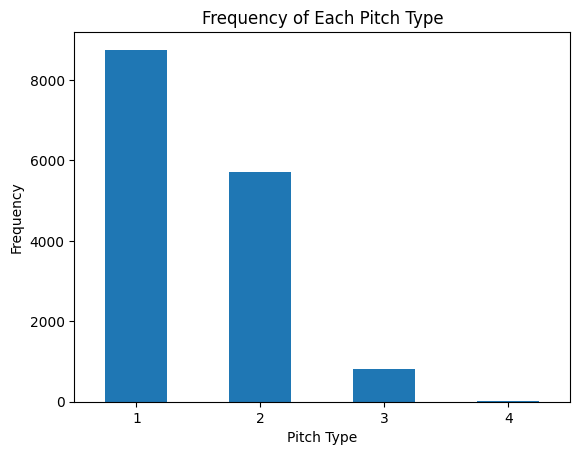

In [167]:
pitch_counts = test_pitcher_df['simple_pitch_type_enc'].value_counts().sort_index()

# Plotting the bar plot
pitch_counts.plot(kind='bar', rot=0)

# Adding labels and title
plt.xlabel('Pitch Type')
plt.ylabel('Frequency')
plt.title('Frequency of Each Pitch Type')

plt.show()

In [168]:
test_pitcher_df['zone'].value_counts()

zone
14.00    3857
11.00    2693
12.00    2334
13.00    1392
6.00      758
5.00      725
3.00      615
2.00      600
9.00      575
4.00      499
1.00      462
8.00      459
7.00      333
Name: count, dtype: int64

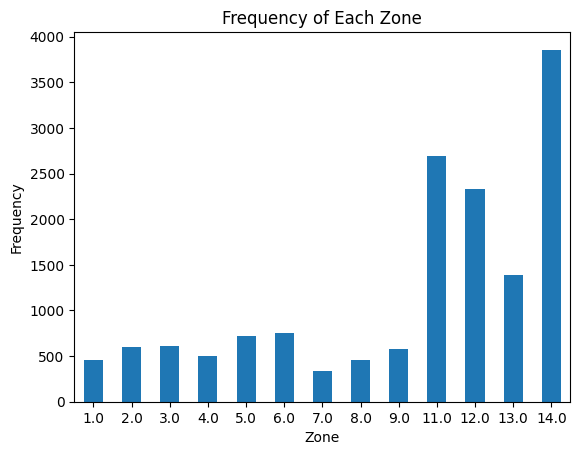

In [169]:
zone_counts = test_pitcher_df['zone'].value_counts().sort_index()

# Plotting the bar plot
zone_counts.plot(kind='bar', rot=0)

# Adding labels and title
plt.xlabel('Zone')
plt.ylabel('Frequency')
plt.title('Frequency of Each Zone')

plt.show()

We will build a dictionary for this.
Note that there's no zone 10, so zone 11 will be encoded as 9, and zone 12-14 will follow.

In [170]:
dictionary_class = {
  1:0,
  2:1,
  3:2,
  4:3,
  5:4,
  6:5,
  7:6,
  8:7,
  9:8,
  11:9,
  12:10,
  13:11,
  14:12
}

In [171]:
new_class = [dictionary_class[class_name] for class_name in test_pitcher_df['zone']]
test_pitcher_df['zone'] = new_class

<ipython-input-171-8428bcf36058>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pitcher_df['zone'] = new_class


In [172]:
new_class = [dictionary_class[class_name] for class_name in test_pitcher_df['simple_pitch_type_enc']]
test_pitcher_df['simple_pitch_type_enc'] = new_class

<ipython-input-172-f5fb949bfca3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pitcher_df['simple_pitch_type_enc'] = new_class


### Split Dataframe by at-bat

Although it's about the same pitcher, it would be better to split his pitching history by at-bats. First, it's less likely the "sequencial relationship" between pitches last between games. Second, this helps serve as a code block for processing the entire dataframe.

In [173]:
chunk_size = 1000  # Adjust based on your memory constraints

# Initialize the dictionary to store the data
ab_data_df = {}

# Number of chunks
num_chunks = len(test_pitcher_df) // chunk_size + 1

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size
    chunk = test_pitcher_df.iloc[start_index:end_index]

    # Process each chunk
    unique_ab_ids = chunk['ab_id'].unique()
    for ab in unique_ab_ids:
        # Filter and drop columns for each unique ab_id
        ab_chunk = chunk[chunk['ab_id'] == ab].drop(columns=['ab_id', 'g_id', 'pitcher_id', 'simple_pitch_type', 'top'])

        if ab not in ab_data_df:
            ab_data_df[ab] = ab_chunk
        else:
            ab_data_df[ab] = pd.concat([ab_data_df[ab], ab_chunk], ignore_index=True)

### Create Sequence

The purpose of creating sequence is to create sub_dataframe for every 3 pitches in each at bat.
If an at-bat has 5 pitches, then 3 dataframe will be generated: pitch 1-3, 2-4 and 3-5.

In [174]:
seq_length = 3
target_columns = ['zone', 'simple_pitch_type_enc']
all_X, all_y = [], []

def create_sequences(df, seq_length, target_columns):
    xs, ys = [], []
    for i in range(len(df) - seq_length + 1):
        x = df.iloc[i:i + seq_length].drop(columns=target_columns).values
        y = df.iloc[i + seq_length - 1][target_columns].values
        xs.append(x)
        ys.append(y)
    # Reshape the arrays to ensure consistent dimensions
    return np.array(xs).reshape(-1, seq_length, df.shape[1] - len(target_columns)), np.array(ys)
for ab_id, data in ab_data_df.items():
    X, y = create_sequences(data, seq_length, target_columns)
    # Append only if sequences were created
    if X.size > 0:
       all_X.append(X)
       all_y.append(y)
#Combine all sequences and labels
# Handle the case where all_X might be empty
if all_X:
  X = np.concatenate(all_X)
  y = np.concatenate(all_y)
else:
    print("No sequences were created. Check your data and sequence length.")
    X = np.array([])
    y = np.array([])

### Train-Test Split, Tensorizing and Data loading

In [175]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [176]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [177]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.from_numpy(y_test)

# Create DataLoader objects for bigger dataset
#train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Class Weight

When we are encoding the target variables, there is a class imbalance problems for both targets. Fastball accounts for 50% of the total pitches, and ball zone (zone 11-14) accounts for 67% of the total pitches. We should calculate the class weight and apply it to the weight loss, hoping it will improve the performance of the model.

In [178]:
# Calculate class weights for output1 (13 classes)
classes1, counts1 = np.unique(y_train[:, 0], return_counts=True)
total_samples1 = len(y_train[:, 0])
class_weights1 = total_samples1 / (len(classes1) * counts1)
class_weights1 = torch.tensor(class_weights1, dtype=torch.float32)

# Calculate class weights for output2 (4 classes)
classes2, counts2 = np.unique(y_train[:, 1], return_counts=True)
total_samples2 = len(y_train[:, 1])
class_weights2 = total_samples2 / (len(classes2) * counts2)

if class_weights2.shape != (4,):
    class_weights2 = np.append(class_weights2, 0)
class_weights2 = torch.tensor(class_weights2, dtype=torch.float32)

### RNN Model Test Pitcher

In [179]:
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size1, output_size2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out1 = nn.Linear(hidden_size, output_size1)
        self.out2 = nn.Linear(hidden_size, output_size2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out1 = F.relu(self.fc1(out))
        out1 = self.dropout(out1)
        out1 = self.out1(out1)

        out2 = F.relu(self.fc2(out))
        out2 = self.dropout(out2)
        out2 = self.out2(out2)

        return out1, out2

# Define model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size1 = 13  # 13 classes
output_size2 = 4   # 4 classes
# Initialize and print the model
model = RNNModel(input_size, hidden_size, output_size1, output_size2)
print(model)




RNNModel(
  (rnn): RNN(58, 50, batch_first=True)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (out1): Linear(in_features=50, out_features=13, bias=True)
  (out2): Linear(in_features=50, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Training



In [180]:
import torch.optim as optim

# Define loss and optimizer
criterion1 = nn.CrossEntropyLoss(weight=class_weights1)  # For output1 with 13 classes
criterion2 = nn.CrossEntropyLoss(weight=class_weights2)  # For output2 with 4 classes
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs1, outputs2 = model(X_train_tensor)

    # Subtract 1 from y_train_tensor to shift the labels to the range 0-12
    loss1 = criterion1(outputs1, (y_train_tensor[:, 0]).long())
    loss2 = criterion2(outputs2, (y_train_tensor[:, 1]).long())

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/20, Loss: 3.9995477199554443
Epoch 2/20, Loss: 4.004126071929932
Epoch 3/20, Loss: 3.9865965843200684
Epoch 4/20, Loss: 3.9677767753601074
Epoch 5/20, Loss: 3.9913454055786133
Epoch 6/20, Loss: 3.953181743621826
Epoch 7/20, Loss: 3.9548697471618652
Epoch 8/20, Loss: 3.981055736541748
Epoch 9/20, Loss: 3.958928108215332
Epoch 10/20, Loss: 3.9484591484069824
Epoch 11/20, Loss: 3.9478201866149902
Epoch 12/20, Loss: 3.979379653930664
Epoch 13/20, Loss: 3.9778642654418945
Epoch 14/20, Loss: 3.947373628616333
Epoch 15/20, Loss: 3.9686896800994873
Epoch 16/20, Loss: 3.9798505306243896
Epoch 17/20, Loss: 3.96362042427063
Epoch 18/20, Loss: 3.9497859477996826
Epoch 19/20, Loss: 3.9597907066345215
Epoch 20/20, Loss: 3.95754075050354


### Evaluation

We will look evaluate the model with loss, accuracy and review of raw output.

#### Training Loss v.s. Test Loss

In [181]:
model.eval()
with torch.no_grad():
    y_pred1, y_pred2 = model(X_test_tensor) # Unpack both outputs of the model
    y_train_pred1, y_train_pred2 = model(X_train_tensor) # Unpack both outputs of the model
    train_loss1 = criterion1(y_train_pred1, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    train_loss2 = criterion2(y_train_pred2, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Train Loss 1: {train_loss1.item():.4f}, Train Loss 2: {train_loss2.item():.4f}')
    # Assuming y_test_tensor also needs to be split for two outputs
    test_loss1 = criterion1(y_pred1, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    test_loss2 = criterion2(y_pred2, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Test Loss 1: {test_loss1.item():.4f}, Test Loss 2: {test_loss2.item():.4f}')

Train Loss 1: 2.6218, Train Loss 2: 1.3612
Test Loss 1: 2.6216, Test Loss 2: 1.3615


When fine tuning the model, we will see if the loss is reduced.

#### Accuracy Score

We should compare the predicted value of both target variables with the actual value to get the accuracy score. This also helps with real-life application

In [182]:
from sklearn.metrics import accuracy_score

# Make predictions
with torch.no_grad():
    y_pred1, y_pred2 = model(X_test_tensor)

    # Check if y_test needs to be split for two outputs and adjust accordingly
    # For example, if y_test is a 2D array where each row represents multiple labels:
    y_test_1 = y_test[:, 0]  # Assuming the first column corresponds to the first output
    y_test_2 = y_test[:, 1]  # Assuming the second column corresponds to the second output

    # Convert model outputs to class predictions
    classification1 = y_pred1.argmax(dim=1).cpu().numpy()
    classification2 = y_pred2.argmax(dim=1).cpu().numpy()

# Calculate accuracy for each output separately
accuracy1 = accuracy_score(y_test_1, classification1)
accuracy2 = accuracy_score(y_test_2, classification2)

print(f"Accuracy score on test set for output 1: {round(accuracy1 * 100, 2)}%")
print(f"Accuracy score on test set for output 2: {round(accuracy2 * 100, 2)}%")

Accuracy score on test set for output 1: 1.72%
Accuracy score on test set for output 2: 52.48%


#### Prediction

Reviewing prediction set is the last step.

In [183]:
# During evaluation, apply softmax to the outputs to get probabilities
with torch.no_grad():
    logits1, logits2 = model(X_test_tensor)
    probabilities1 = F.softmax(logits1, dim=1)
    probabilities2 = F.softmax(logits2, dim=1)
    predictions1 = probabilities1.argmax(dim=1)
    predictions2 = probabilities2.argmax(dim=1)
    print("Logits 1:", logits1)
    print("Probabilities 1:", probabilities1)
    print("Predictions 1:", predictions1)
    print("Logits 2:", logits2)
    print("Probabilities 2:", probabilities2)
    print("Predictions 2:", predictions2)

Logits 1: tensor([[-0.0392,  0.0190,  0.0478,  ..., -0.0061,  0.0081,  0.0342],
        [-0.0392,  0.0190,  0.0478,  ..., -0.0061,  0.0081,  0.0342],
        [-0.0392,  0.0190,  0.0478,  ..., -0.0061,  0.0081,  0.0342],
        ...,
        [-0.0392,  0.0190,  0.0478,  ..., -0.0061,  0.0081,  0.0342],
        [-0.0392,  0.0190,  0.0478,  ..., -0.0061,  0.0081,  0.0342],
        [-0.0392,  0.0190,  0.0478,  ..., -0.0061,  0.0081,  0.0342]])
Probabilities 1: tensor([[0.0726, 0.0770, 0.0792,  ..., 0.0751, 0.0762, 0.0782],
        [0.0726, 0.0770, 0.0792,  ..., 0.0751, 0.0762, 0.0782],
        [0.0726, 0.0770, 0.0792,  ..., 0.0751, 0.0762, 0.0782],
        ...,
        [0.0726, 0.0770, 0.0792,  ..., 0.0751, 0.0762, 0.0782],
        [0.0726, 0.0770, 0.0792,  ..., 0.0751, 0.0762, 0.0782],
        [0.0726, 0.0770, 0.0792,  ..., 0.0751, 0.0762, 0.0782]])
Predictions 1: tensor([6, 6, 6,  ..., 6, 6, 6])
Logits 2: tensor([[-0.0957, -0.1560, -0.1302, -0.1048],
        [-0.0957, -0.1560, -0.1302, -

Unfortunately, we see that when predicting the pitch type, the model predict types to be fastball for all rows. In addition, each vector in the tensor and probability is the same. This means something is wrong with the data or training.

##Trial Model for One Pitcher - Softmax Regression

Due to the terrible result of RNN model, I will use softmax regression as an alternative for prediction.

#### Softmax Regression on Zone

In [187]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Reshape X_train to 2D if it's 3D
if X_train.ndim == 3:
    X_train = X_train.reshape(X_train.shape[0], -1)
if X_test.ndim == 3:
    X_test = X_test.reshape(X_test.shape[0], -1)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

model.fit(X_train, y_train[:,0])


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test[:,0], y_pred)
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test[:,0], y_pred))

[12. 12. 12. ... 12. 12. 12.]
Accuracy: 0.28
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        58
         1.0       0.00      0.00      0.00        57
         2.0       0.00      0.00      0.00        69
         3.0       0.00      0.00      0.00        44
         4.0       0.00      0.00      0.00        68
         5.0       0.00      0.00      0.00        75
         6.0       0.00      0.00      0.00        28
         7.0       0.00      0.00      0.00        54
         8.0       0.00      0.00      0.00        64
         9.0       0.00      0.00      0.00       274
        10.0       0.00      0.00      0.00       266
        11.0       0.00      0.00      0.00       121
        12.0       0.28      1.00      0.43       453

    accuracy                           0.28      1631
   macro avg       0.02      0.08      0.03      1631
weighted avg       0.08      0.28      0.12      1631



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model is not doing good. It predicts that all the pitches goes to zone 14, which is wrong for sure. The 28% accuracy is because 28% of the total pitches goes to zone 14. We will come back to it to see what goes wrong.

#### Softmax Regression on Pitch Type

In [188]:
model.fit(X_train, y_train[:,1])


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test[:,1], y_pred)
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test[:,1], y_pred))

[0. 0. 1. ... 0. 0. 1.]
Accuracy: 0.55
              precision    recall  f1-score   support

         0.0       0.55      0.82      0.66       856
         1.0       0.52      0.27      0.36       693
         2.0       0.00      0.00      0.00        80
         3.0       0.00      0.00      0.00         2

    accuracy                           0.55      1631
   macro avg       0.27      0.27      0.25      1631
weighted avg       0.51      0.55      0.50      1631



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Due to the smaller number of classes, the model performs better when predicting pitch type. However, this model didn't predict any off-speed pitches.